## 1. Make classification data

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles

X1        X2  label
0    0.754246  0.231481      1
1   -0.756159  0.153259      1
2   -0.815392  0.173282      1
3   -0.393731  0.692883      1
4    0.442208 -0.896723      0
..        ...       ...    ...
995  0.244054  0.944125      0
996 -0.978655 -0.272373      0
997 -0.136900 -0.810012      1
998  0.670362 -0.767502      0
999  0.281057  0.963824      0

[1000 rows x 3 columns]

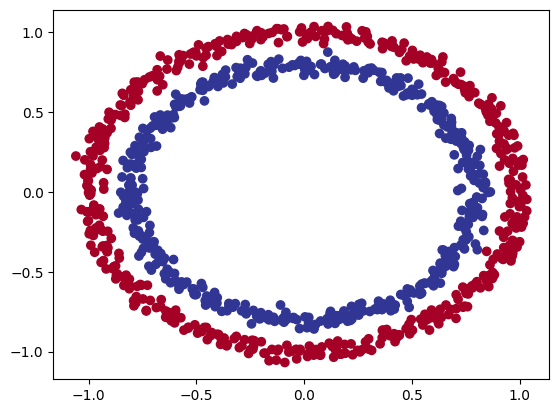

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
# Checking shape of input and output
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample}, y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape}, y: {y_sample.shape}") # since y is scalar, it has no shape

Values for one sample of X: [0.75424625 0.23148074], y: 1
Shapes for one sample of X: (2,), y: ()


### 1.2 Turning data into tensors and create test and train split


In [8]:
import torch
torch.__version__

'2.6.0+cu124'

In [9]:
type(X)

numpy.ndarray

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into train and test split from sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Building a model to classify red and blue dots.

To do so we will:
1. Device agonistic code
2. Construct a Model (subclassing `nn.Module`)
3. Define a loss function
4. Creat training and testing loop

In [14]:
# Import torch and nn
import torch
from torch import nn

# Make device = gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Creating a model:
1. Subclass nn.Module
2. Create 2 `nn.Linear` layers (layers capable of handling the shape of data)
3. Define forward method
4. Instatiate an instance of the model class and send it to trget device

In [16]:
# 1. Constructing a model class
class CircleModelV0(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    # 2. Create 2 nn.Linear() layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes 2 input and upscale it to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and give output

    # with nn.Sequential
    # self.two_linear_layers = nn.Sequential(
    #    nn.Linear(in_features=2, out_features=5),
    #    nn.Linear(in_features=5, out_featues=1)
    #)

  # 3. Define forward
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # X -> layer_1 -> layer_2 -> output
    # return self.two_linear_layers

# Create an instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cpu')

In [18]:
# Repicating model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1912, -0.0626],
                      [ 0.4176, -0.4842],
                      [-0.3700,  0.3948],
                      [-0.6398, -0.2174],
                      [-0.4408,  0.3603]])),
             ('0.bias', tensor([ 0.2747, -0.3182,  0.6963,  0.4556,  0.5915])),
             ('1.weight',
              tensor([[ 0.2676,  0.0082, -0.4394, -0.3946,  0.4392]])),
             ('1.bias', tensor([-0.0165]))])

In [20]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Predictions\nLength: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nTest Samples\nLength: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Predictions
Length: 200, Shape: torch.Size([200, 1])

Test Samples
Length: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2410],
        [-0.1194],
        [-0.3812],
        [-0.2020],
        [-0.0976],
        [-0.0255],
        [ 0.0922],
        [ 0.1149],
        [-0.3930],
        [-0.1081]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setting up Loss fn and Optimizer
Loss fn to use:

For regression -> MAE or MSE

For classification -> BCE(binary cross entropy) or CE/CCE(Categorical Cross entropy)

Optimizer:

SGD or Adam

In [21]:
# Loss fn
# loss_fn = nn.BCELoss() # This fn requires inputs to have gone through sigmoid activation fn
loss_fn = nn.BCEWithLogitsLoss() # this fn has sigmoid activation fn built in

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [22]:
# Evaluation matrix
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true)) * 100
  return acc

## 3. Train Model

1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. Loss backwards (backpropogation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probablities** by passing them to some kind of activation fn (e.g. sigmoid for binary, softmax for multiclass)

Then we can convert our model's prediction probablities to **prediction labels** by either ounding them or takingthe `argmax()`

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2410],
        [-0.1194],
        [-0.3812],
        [-0.2020],
        [-0.0976]])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use sigmoid activation function on our model's logits to turn them into prediction prob
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4400],
        [0.4702],
        [0.4058],
        [0.4497],
        [0.4756]])

For our prediction probablity values, we perform range-style (decision boundary) rounding on them.
* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

In [26]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building Training and Testing loop


In [28]:
# Training and Testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epoch settings
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training for loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

  # 2. Calculate Acc and Loss
  # loss = loss_fn(torch.sigmoid(y_logits), # BCELoss expects predictions prob as inputs
  #                              y_train)
  loss = loss_fn(y_logits,
                 y_train) # nn.BCEWithLogitsLoss expects logits as input and not y_pred.
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69996, Accuracy: 47.00% | Test loss: 0.70377, Test acc: 43.00%
Epoch: 10 | Loss: 0.69548, Accuracy: 48.50% | Test loss: 0.69990, Test acc: 49.50%
Epoch: 20 | Loss: 0.69432, Accuracy: 50.00% | Test loss: 0.69877, Test acc: 48.50%
Epoch: 30 | Loss: 0.69392, Accuracy: 50.12% | Test loss: 0.69823, Test acc: 48.50%
Epoch: 40 | Loss: 0.69370, Accuracy: 50.62% | Test loss: 0.69784, Test acc: 47.50%
Epoch: 50 | Loss: 0.69356, Accuracy: 50.62% | Test loss: 0.69751, Test acc: 46.50%
Epoch: 60 | Loss: 0.69345, Accuracy: 50.62% | Test loss: 0.69722, Test acc: 47.00%
Epoch: 70 | Loss: 0.69336, Accuracy: 51.25% | Test loss: 0.69697, Test acc: 47.00%
Epoch: 80 | Loss: 0.69329, Accuracy: 51.00% | Test loss: 0.69675, Test acc: 48.00%
Epoch: 90 | Loss: 0.69323, Accuracy: 51.38% | Test loss: 0.69655, Test acc: 47.50%
Epoch: 100 | Loss: 0.69319, Accuracy: 51.12% | Test loss: 0.69638, Test acc: 46.50%
Epoch: 110 | Loss: 0.69315, Accuracy: 51.00% | Test loss: 0.69622, Test acc: 47.00%
Epo

## 4. Make predictions and evaluate the model

from the metrics it looks like our model isn't learning anything

Let's check it with making predictions and evaluating them


In [29]:
import requests
from pathlib import Path

# Download helper functions from Lear PyTorch repo (if its not already downlaoded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py exist. Skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


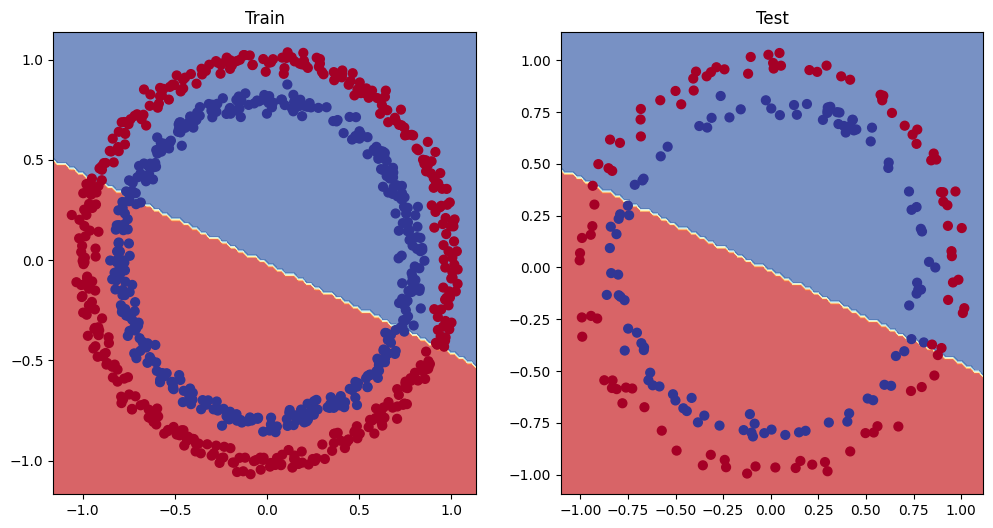

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give model more chances to learn about patterns in data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - more epochs
* Changing the activation function
* Change the learning rate
* Change the loss function

These options are from model's perspective, as they deal with model and **not** the data

These are **hyperparameters**

In [36]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Create a loss fn
loss_fn = nn.BCEWithLogitsLoss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [41]:
# Training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 1000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels

  # 2. Loss fn
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropogation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. FOrward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71086, Accuracy: 50.00% | Test loss: 0.70706, Test acc: 50.00%
Epoch: 100 | Loss: 0.69309, Accuracy: 49.00% | Test loss: 0.69348, Test acc: 49.00%
Epoch: 200 | Loss: 0.69300, Accuracy: 50.88% | Test loss: 0.69425, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69452, Test acc: 45.50%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69462, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69466, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


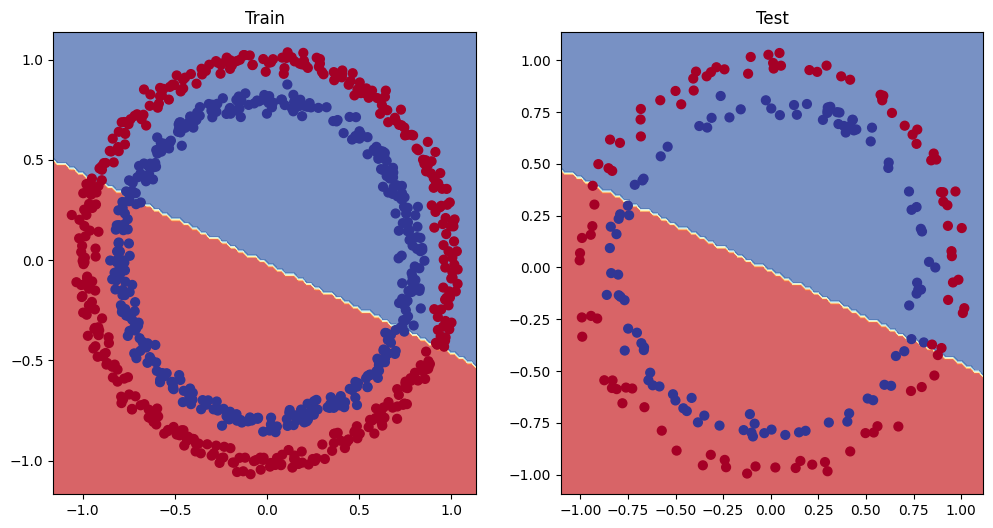

In [42]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
###